# Reinforcement Learning for Trading - Deep Q-learning & the stock market

To train a trading agent, we need to create a market environment that provides price and other information, offers trading-related actions, and keeps track of the portfolio to reward the agent accordingly.

## How to Design an OpenAI trading environment

The OpenAI Gym allows for the design, registration, and utilization of environments that adhere to its architecture, as described in its [documentation](https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym). The [trading_env.py](trading_env.py) file implements an example that illustrates how to create a class that implements the requisite `step()` and `reset()` methods.

The trading environment consists of three classes that interact to facilitate the agent's activities:
 1. The `DataSource` class loads a time series, generates a few features, and provides the latest observation to the agent at each time step. 
 2. `TradingSimulator` tracks the positions, trades and cost, and the performance. It also implements and records the results of a buy-and-hold benchmark strategy. 
 3. `TradingEnvironment` itself orchestrates the process. 

The book chapter explains these elements in more detail.

## A basic trading game

To train the agent, we need to set up a simple game with a limited set of options, a relatively low-dimensional state, and other parameters that can be easily modified and extended.

More specifically, the environment samples a stock price time series for a single ticker using a random start date to simulate a trading period that, by default, contains 252 days, or 1 year. The state contains the (scaled) price and volume, as well as some technical indicators like the percentile ranks of price and volume, a relative strength index (RSI), as well as 5- and 21-day returns. The agent can choose from three actions:

- **Buy**: Invest capital for a long position in the stock
- **Flat**: Hold cash only
- **Sell short**: Take a short position equal to the amount of capital

The environment accounts for trading cost, which is set to 10bps by default. It also deducts a 1bps time cost per period. It tracks the net asset value (NAV) of the agent's portfolio and compares it against the market portfolio (which trades frictionless to raise the bar for the agent).

We use the same DDQN agent and neural network architecture that successfully learned to navigate the Lunar Lander environment. We let exploration continue for 500,000 time steps (~2,000 1yr trading periods) with linear decay of ε to 0.1 and exponential decay at a factor of 0.9999 thereafter.

## Imports & Settings

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

### Settings

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# %%

sns.set_style('whitegrid')

# %%

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

# %%

results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

# %% md

### Helper functions

# %%

def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

Using CPU


## Set up Gym Environment

Before using the custom environment, just like with the Lunar Lander environment, we need to register it:

In [4]:
trading_days = 252

# %%

register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days
)

# %% md

### Initialize Trading Environment

# %% md

## We can instantiate the environment by using the desired trading costs and ticker:

# %%

trading_cost_bps = 1e-3
time_cost_bps = 1e-4

# %%

f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}'

'Trading costs: 0.10% | Time costs: 0.01%'

In [5]:
trading_environment = gym.make('trading-v0')
trading_environment.env.trading_days = trading_days
trading_environment.env.trading_cost_bps = trading_cost_bps
trading_environment.env.time_cost_bps = time_cost_bps
trading_environment.env.ticker = 'AAPL'
trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570 entries, 1 to 1618
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  1570 non-null   float64
dtypes: float64(1)
memory usage: 24.5 KB


[42]

### Get Environment Params

In [6]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps


# %% md

## Define Trading Agent

# %%

class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        print(state)
        print("end state")
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [7]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

# %% md

### NN Architecture

# %%

architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

# %% md

### Experience Replay

# %%

replay_capacity = int(1e6)
batch_size = 4096

# %% md

### $\epsilon$-greedy Policy

# %%

epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

## Create DDQN Agent

We will use [TensorFlow](https://www.tensorflow.org/) to create our Double Deep Q-Network .

In [8]:
tf.keras.backend.clear_session()

# %%

ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

# %%

ddqn.online_network.summary()

# %% md

## Run Experiment

# %% md

### Set parameters

# %%

total_steps = 0
max_episodes = 10

# %% md

### Initialize variables

# %%

episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               512       
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


## Visualization

In [9]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon))

## Train Agent


In [10]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
    
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav 
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    # market nav 
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs.append(diff)
    
    if episode % 10 == 0:
        track_results(episode, 
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[-100:]), 
                      np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), 
                      np.mean(market_navs[-10:]), 
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

[[-0.00048497]]
end state
0.0
[[-0.00222384]]
end state
-1.0
[[0.00056733]]
end state
0.0
[[0.00117452]]
end state
1.0
[[0.00093042]]
end state
-1.0
[[-4.0415471e-05]]
end state
1.0
[[-0.00242503]]
end state
0.0
[[0.00024309]]
end state
0.0
[[0.00089112]]
end state
-1.0
[[-0.00044516]]
end state
0.0
[[-0.00538483]]
end state
-1.0
[[-0.00052919]]
end state
1.0
[[0.00012218]]
end state
1.0
[[-0.00464245]]
end state
1.0
[[-0.00167744]]
end state
1.0
[[-0.00745871]]
end state
-1.0
[[0.00074322]]
end state
1.0
[[-0.00107274]]
end state
-1.0
[[-0.00644335]]
end state
-1.0
[[0.00922885]]
end state
0.0
[[-0.00230671]]
end state
0.0
[[-0.00169275]]
end state
1.0
[[-0.00186104]]
end state
-1.0
[[0.00886679]]
end state
1.0
[[-0.008871]]
end state
0.0
[[0.00812166]]
end state
0.0
[[-0.00065765]]
end state
0.0


KeyboardInterrupt: 

### Store Results

In [27]:
print(len(diffs))
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

0


ValueError: All arrays must be of the same length

In [28]:
results.to_csv(results_path / 'results.csv', index=False)

In [ ]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

### Evaluate Results

In [ ]:
results.info()

The following diagram shows the rolling average of agent and market returns over 100 periods on the left, and the share of the last 100 periods the agent outperformed the market on the right. It uses AAPL stock data with some 9,000 daily price and volume observations, corresponding to ~35 years of data. 

It shows how the agent's performance improves significantly while exploring at a higher rate over the first ~600 periods (that is, years) and approaches a level where it outperforms the market around 40 percent of the time, despite transaction costs. In an increasing number of instances, it beats the market over half the time out of 100 periods:

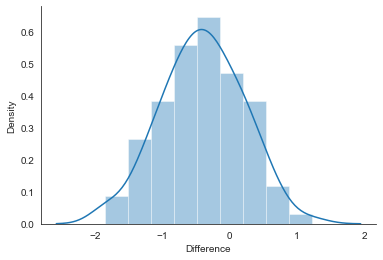

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)

### Evaluate Results

In [30]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              100 non-null    float64
 1   Market             100 non-null    float64
 2   Difference         100 non-null    float64
 3   Strategy Wins (%)  1 non-null      float64
dtypes: float64(4)
memory usage: 3.9 KB


The following diagram shows the rolling average of agent and market returns over 100 periods on the left, and the share of the last 100 periods the agent outperformed the market on the right. It uses AAPL stock data with some 9,000 daily price and volume observations, corresponding to ~35 years of data. 

It shows how the agent's performance improves significantly while exploring at a higher rate over the first ~600 periods (that is, years) and approaches a level where it outperforms the market around 40 percent of the time, despite transaction costs. In an increasing number of instances, it beats the market over half the time out of 100 periods:

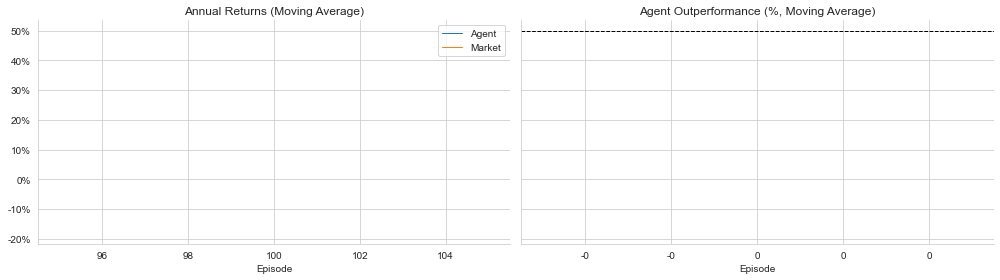

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)

## Summary

This relatively simple agent uses **no information beyond the latest market data and the reward signal** compared to the machine learning models we covered elsewhere in this book. Nonetheless, it learns to make a profit and achieve performance similar to that of the market (after training on <1,000 years' worth of data, which takes only a fraction of the time on a GPU).

Keep in mind that using a single stock also increases the **risk of overfitting** to the data — by a lot. You can test your trained agent on new data using the saved model (see the notebook for Lunar Lander).

In summary, we have demonstrated the **mechanics of setting up an RL trading environment** and experimented with a basic agent that uses a small number of technical indicators. You should **try to extend both the environment and the agent** - for example, by allowing it to choose from several assets, size the positions, and manage risks.

Reinforcement learning is often considered **one of the most promising approaches to algorithmic trading** because it most accurately models the task an investor is facing. However, our dramatically simplified examples illustrate that creating a **realistic environment poses a considerable challenge**. Moreover, deep reinforcement learning that has achieved impressive breakthroughs in other domains may face greater obstacles given the noisy nature of financial data, which makes it even harder to learn a value function based on delayed rewards.

Nonetheless, the substantial interest in this subject makes it likely that institutional investors are working on larger-scale experiments that may yield tangible results. An interesting complementary approach beyond the scope of this book is **Inverse Reinforcement Learning**, which aims to identify the reward function of an agent(for example, a human trader) given its observed behavior; see [Arora and Doshi (2019)](https://www.semanticscholar.org/paper/A-Survey-of-Inverse-Reinforcement-Learning%3A-Methods-Arora-Doshi/9d4d8509f6da094a7c31e063f307e0e8592db27f) for a survey and [Roa-Vicens et al. (2019)](https://deepai.org/publication/towards-inverse-reinforcement-learning-for-limit-order-book-dynamics) for an application on trading in the limit-order book context.
